In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
sns.set_style("white")
sns.set_context("paper")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

## 0. Load data

In [2]:
def show_memory_alloc(df: pd.DataFrame) -> None:
    mem = round(df.memory_usage().sum()/1024/1024/1024, 2)
    print(f"{mem} GB")

### 0.1 SAU data

In [3]:
t0 = datetime.now()
# --------------------- Load big dataset --------------------- #
file = "data/spatial catches of elasmobranchii in 2010-2018.csv"
df = pd.read_csv(file)
# ------------------------------------------------------------ #
t1 = datetime.now()
print(f"Time taken to load file: {(t1-t0).seconds}s, {(t1-t0).microseconds}ms")
show_memory_alloc(df)
df

Time taken to load file: 41s, 546391ms
2.81 GB


,fishing_entity,cell_id,lon,lat,year,scientific_name,common_name,sector_type,catch_type,reporting_status,gear,sum
0,Algeria,73811,5.25,38.75,2010,Carcharhinidae,Requiem sharks,Industrial,Landings,Unreported,unknown class,0.000035
1,Algeria,73811,5.25,38.75,2010,Elasmobranchii,"Sharks, rays, skates",Industrial,Landings,Unreported,unknown class,0.032026
2,Algeria,73811,5.25,38.75,2010,Mustelus mustelus,Smooth-hound,Industrial,Landings,Reported,unknown class,0.000050
3,Algeria,73811,5.25,38.75,2011,Batoidea,"Batoids, skates, rays, sawfishes",Industrial,Landings,Unreported,unknown class,0.000004
4,Algeria,73811,5.25,38.75,2011,Carcharhinidae,Requiem sharks,Industrial,Landings,Unreported,unknown class,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...
31390122,Yemen,135089,44.25,-3.75,2014,Elasmobranchii,"Sharks, rays, skates",Industrial,Landings,Unreported,bottom trawl,0.150750
31390123,Yemen,135089,44.25,-3.75,2015,Elasmobranchii,"Sharks, rays, skates",Industrial,Landings,Unreported,bottom trawl,0.150750
31390124,Yemen,135089,44.25,-3.75,2016,Elasmobranchii,"Sharks, rays, skates",Industrial,Landings,Unreported,bottom trawl,0.150750
31390125,Yemen,135089,44.25,-3.75,2017,Elasmobranchii,"Sharks, rays, skates",Industrial,Landings,Unreported,bottom trawl,0.150750


### 0.2 Bycatch fate data

In [4]:
# Fate after bycatch data
fate = pd.read_excel("data/bycatch_fate.xlsx")
fate.rfmo.fillna("Non-RFMO", inplace=True)
fate.family.fillna("Sharks-nei", inplace=True)
fate.fate_type.replace(
    "finned (fins kept, carcass discarded)", "discard_dead",
    inplace=True
)

In [5]:
# Split the rows with discard_unknown randomly nto two equal groups
dead, alive = train_test_split(fate[fate.fate_type == "discard_unknown"], test_size=0.5)

# Assign them values from acceptable categories
fate.loc[dead.index, "fate_type"] = "discard_dead"
fate.loc[alive.index, "fate_type"] = "discard_alive"

### 0.3 Post-release mortality, taxa, gear data and list of true shark species

In [6]:
# Post release mortality data
mortality = pd.read_excel("data/post_release_mortality.xlsx")
mortality.family.fillna("unknown", inplace=True)

# Taxonomy data
taxa = pd.read_csv("data/sau_spp_taxonomy_ref.csv")

# Gear data
gear = pd.read_excel("data/Gear_groups_SAUP.xlsx")

# List of true shark species
shark_species_data = pd.read_excel("data/List of true shark species_SAUP_2010-2018.xlsx", index_col=0)
shark_species_data.columns = [col.lower() for col in shark_species_data.columns]
shark_list = shark_species_data.common_name

## 1. EDA of Mortality Dataset

In [7]:
pt = mortality.pivot_table(
    index=["ocean", "gear_class", "family"],
    columns="estimate_type",
    values="sample_size",
    aggfunc=np.sum,
).drop("post-release survival", axis="columns")
display(pt)
pt.to_excel("outputs/mortality-by-gear-by-family.xlsx")

estimate_type                       at-vessel mortality  \
ocean    gear_class family                                
Atlantic gillnet    Carcharhinidae               1921.0   
                    Rajidae                       975.0   
                    Sphyrnidae                    188.0   
                    Squalidae                    2284.0   
         handline   Carcharhinidae                 32.0   
...                                                 ...   
Southern longline   Rhinidae                        8.0   
                    Rhinobatidae                    2.0   
                    Sphyrnidae                     65.0   
                    Triakidae                      22.0   
         trawl      Triakidae                      24.0   

estimate_type                       post-release mortality  
ocean    gear_class family                                  
Atlantic gillnet    Carcharhinidae                  2898.0  
                    Rajidae                            NaN  
                    Sphyrnidae                      4352.0  
                    Squalidae                        480.0  
         handline   Carcharhinidae                   193.0  
...                                                    ...  
Southern longline   Rhinidae                           NaN  
                    Rhinobatidae                       NaN  
                    Sphyrnidae                         NaN  
                    Triakidae                        117.0  
         trawl      Triakidae                         41.0  

[77 rows x 2 columns]

### 1.1 BY family

In [8]:
mortalities_only = mortality[mortality.estimate_type != "post-release survival"]
pt = mortalities_only.pivot_table(
    index=["ocean", "family"],
    columns="estimate_type",
    values="sample_size",
    aggfunc=np.sum,
)
display(pt)
pt.to_excel("outputs/mortality-by-family.xlsx")

estimate_type                at-vessel mortality  post-release mortality
ocean    family                                                         
Atlantic Alopiidae                        2328.0                     NaN
         Carcharhinidae                 175039.0                  3739.0
         Centrophoridae                    439.0                    22.0
         Dasyatidae                        396.0                     NaN
         Ginglymostomatidae               1629.0                    33.0
         Hexanchidae                        22.0                     NaN
         Lamnidae                         7056.0                   171.0
         Orectolobidae                     213.0                     NaN
         Pseudocarchariidae               1621.0                     NaN
         Rajidae                          5664.0                   462.0
         Rhincodontidae                    107.0                     NaN
         Scyliorhinidae                     24.0                     NaN
         Somniosidae                        49.0                     NaN
         Sphyrnidae                       3903.0                  4352.0
         Squalidae                        2462.0                   552.0
         Triakidae                        2062.0                    49.0
         unknown                           113.0                     NaN
Indian   Aetobatidae                         3.0                     NaN
         Carcharhinidae                    121.0                    27.0
         Dasyatidae                        107.0                     NaN
         Gymnuridae                         84.0                     NaN
         Hemigaleidae                        2.0                     NaN
         Myliobatidae                        8.0                     NaN
         Rhincodontidae                     38.0                     NaN
         Rhinidae                           15.0                     NaN
         Rhinobatidae                       28.0                     NaN
         Scyliorhinidae                     47.0                     NaN
         Sphyrnidae                        169.0                     NaN
         Squatinidae                        10.0                     NaN
         Torpedinidae                        5.0                     NaN
         Triakidae                          14.0                     NaN
Pacific  Alopiidae                        3076.0                    95.0
         Carcharhinidae                  16884.0                   347.0
         Dasyatidae                        613.0                     NaN
         Heterodontidae                   1452.0                     NaN
         Hexanchidae                       202.0                     NaN
         Lamnidae                         2927.0                   188.0
         Mobulidae                           NaN                     7.0
         Myliobatidae                      133.0                     NaN
         Parascyllidae                      24.0                     NaN
         Pristiophoridae                   675.0                     NaN
         Pseudocarchariidae                139.0                     NaN
         Scyliorhinidae                   1977.0                     NaN
         Sphyrnidae                        254.0                     3.0
         Squalidae                        1230.0                     NaN
         Squatinidae                        56.0                     NaN
         Triakidae                        5310.0                     NaN
Southern Carcharhinidae                    527.0                     NaN
         Dasyatidae                         18.0                     NaN
         Lamnidae                           12.0                     NaN
         Orectolobidae                      18.0                     NaN
         Rhinidae                            8.0                     NaN
         Rhinobatidae                        2.0          

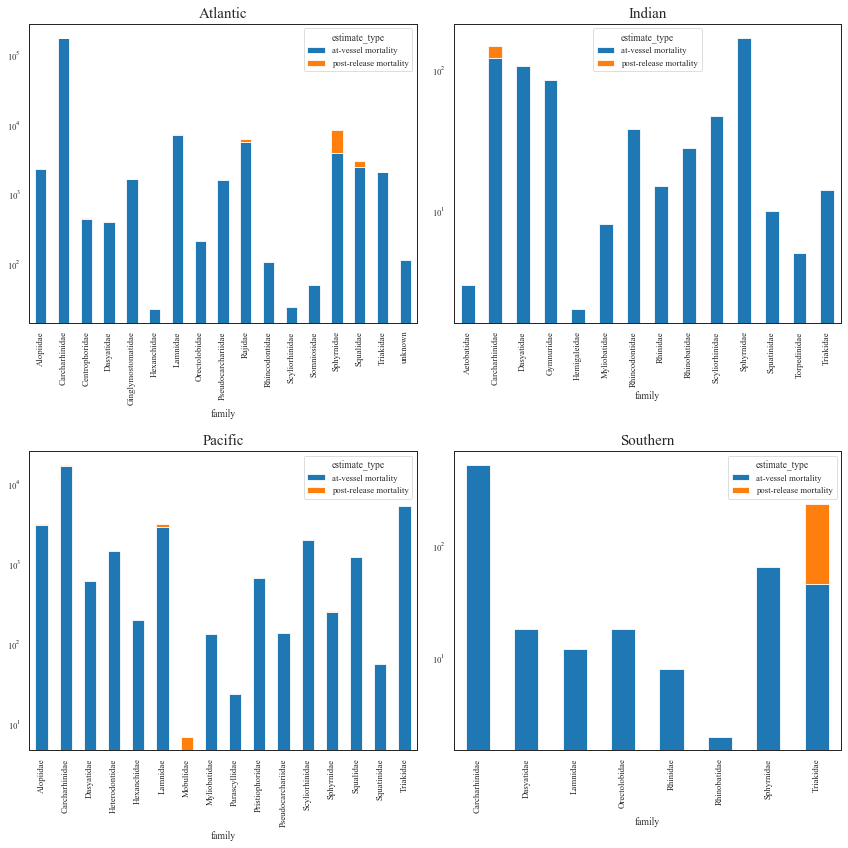

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
for ocean, axe in zip(pt.index.levels[0], axes.flatten()):
    axe = pt.loc[ocean].plot(kind="bar", stacked=True, ax=axe)
    axe.set_title(ocean, fontsize=15)
    axe.set_yscale("log")
    axe.set_ylabel("mortality estimate (log)")
    axe.set_ylabel("")
plt.tight_layout()

plt.savefig("outputs/mortality-estimates-by-family.jpg", dpi=300)

### 1.2 BY Gear

In [10]:
pt = mortality.pivot_table(
    index=["ocean", "gear_class"],
    columns="estimate_type",
    values="sample_size",
    aggfunc=np.sum,
).drop("post-release survival", axis="columns")
display(pt)
pt.to_excel("outputs/mortality-by-family.xlsx")

estimate_type           at-vessel mortality  post-release mortality
ocean    gear_class                                                
Atlantic gillnet                     5368.0                  7730.0
         handline                      32.0                   261.0
         longline                  193798.0                   927.0
         purse seine                  107.0                     NaN
         trawl                       3822.0                   462.0
Indian   gillnet                       64.0                     NaN
         purse seine                   38.0                    27.0
         trawl                        549.0                     NaN
Pacific  gillnet                    11532.0                    28.0
         longline                   23420.0                   529.0
         pole and line                  NaN                    37.0
         purse seine                    NaN                    46.0
Southern gillnet                        NaN                    30.0
         longline                     672.0                   117.0
         trawl                         24.0                    41.0

## 3. Mortality estimate

### 3.1 Prepare data
We need to merge some data from the taxa and gear datasets.

#### 3.1.1 Keep only shark data

In [11]:
df = df[df["common_name"].isin(shark_list)]

#### 3.1.2 Merge with gear and taxa data

In [12]:
orig_shape = df.shape

# Merge with taxa data
df = df.merge(
    taxa[["common_name", "family_name", "order_name", "genus"]],
    on="common_name", how="left"
)
if orig_shape[0] == df.shape[0]:
    print("Validation successfull! Row lengths preserved.")
else:
    print(f"Validation failed! new shape: {df.shape}, old shape: {orig_shape}")

Validation successfull! Row lengths preserved.


In [13]:
# Merge with gear data
df = df.merge(
    gear, on="gear", how="left"
)
if orig_shape[0] == df.shape[0]:
    print("Validation successfull! Row lengths preserved.")
else:
    print(f"Validation failed! new shape: {df.shape}, old shape: {orig_shape}")

Validation successfull! Row lengths preserved.


#### 3.1.3 Seperate coastal and offshore species

In [14]:
# Offshore species are those that are caught in LL or PS
offshore = df[df.gear_group.isin(["longline", "purse seine"])]

# Coastal species are those that are not caught in LL or PS
coastal = df[~df.gear_group.isin(["longline", "purse seine"])]

print("Validation successfull!") if (len(offshore)+len(coastal)==len(df)) else 0

Validation successfull!


### 3.2 Mortality calculation
$$ mortality = sum(n_{catch} * p_{fate} * m_{fate}) $$

Sum of the mortalities for three different fates:
1. Mortality of sharks discarded alive
2. Mortality of sharks discarded dead
3. Mortality of sharks retained

In [15]:
fates = ["discard_alive", "discard_dead", "retained"]

median_weight = {
    "coastal": 20.75,
    "offshore": 36,
}

non_shark_families = [
    "Dasyatidae",
    "Mobulidae",
    "Myliobatidae",
    "Rajidae",
    "Torpedinidae",
]

non_shark_families2 = [
    "Aetobatidae",
    "Dasyatidae",
    "Gymnuridae",
    "Mobulidae",
    "Myliobatidae"
    "Rajidae",
    "Rhinidae",
    "Rhinobatidae",
    "Torpedinidae"
]

#### 3.2.1 Coastal Species
- Median weight = 20.75 kgs
- NON-RFMO
- Sharks only

##### 3.2.1.1 Mortality of sharks discarded alive

In [16]:
avg_weight = 20.75
total_catch = coastal[coastal.catch_type == "Discards"]["sum"].sum()
print(total_catch*1000)
n_catch = int(total_catch*1000/avg_weight)
n_catch

978150947.5728785


47139804

In [17]:
def catch_count(df: pd.DataFrame, fate: str, med_weight: float) -> int:
    """
    Calculate the number of individual sharks from total catch amounts.
    
    Parameters
    ----------
    df: pd.DataFrame
        Data for either coastal or offshore shark species.
    fate: str
        The fate for which mortality is being calculated.
        Allowed values: ["discard_alive", "discard_dead", "retained"]
    med_weight: float
        Median weight of coastal or offshore shark species.
    Returns
    -------
    catch_count: int
        The number of individual sharks caught.
    """
    if fate == "retained":
        total_catch = df[df.catch_type == "Landings"]["sum"].sum()
    else:
        total_catch = df[df.catch_type == "Discards"]["sum"].sum()
    catch_count = int(total_catch*1000/med_weight)
    return catch_count

In [18]:
catch_count(coastal, "discard_alive", median_weight["coastal"]) == n_catch

True

probability of being discarded alive

In [19]:
# Keep species that are not in the above list
fate_shark = fate[~fate.family.isin(non_shark_families)]
# Non-RFMO data
fate_non_rfmo_shark = fate_shark[fate_shark.rfmo == "Non-RFMO"]
# RFMO data
fate_rfmo_shark = fate_shark[fate_shark.rfmo != "Non-RFMO"]

In [20]:
# Probabilities of each fate
fate_probs = (
    fate_non_rfmo_shark.groupby(["fate_type"])["sample_size"].sum() 
    / fate_non_rfmo_shark.groupby(["fate_type"])["sample_size"].sum().sum()
)
#display(fate_probs)

# Probability of being discarded alive
discard_alive_prob = fate_probs[fate_probs.index == "discard_alive"].values[0]
discard_alive_prob

0.7650071884319712

In [21]:
def p_fate(fate_df: pd.DataFrame, fate: str, domain: str) -> float:
    """
    Calculate the probability of the given fate for either coastal or offshore species.
    
    Parameters
    ----------
    fate_df: pd.DataFrame
        The fate dataset to calculate fate proababilities.
    fate: str
        The fate to calculate probability for.
        Allowed values: ["discard_alive", "discard_dead", "retained"]
    domain: str
        Allowed values: ["coastal", "offshore"]
    
    Returns
    -------
    p_fate: float
        The probability of the given fate.
    """
    fate_shark = fate_df[~fate_df.family.isin(non_shark_families)]
    if domain == "coastal":
        shark_fates = fate_shark[fate_shark.rfmo == "Non-RFMO"]
    else:
        shark_fates = fate_shark[fate_shark.rfmo != "Non-RFMO"]
    
    # Probabilities of each fate
    fate_probs = (
        shark_fates.groupby(["fate_type"])["sample_size"].sum() 
        / shark_fates.groupby(["fate_type"])["sample_size"].sum().sum()
    )
    #display(fate_probs)

    # Probability of given fate
    if (fate == "retained") and (domain == "coastal"):
        p_fate = fate_probs.iloc[-2:].sum()
    elif (fate == "retained") and (domain == "offshore"):
        p_fate = fate_probs.loc["retained_whole"]
    else:
        p_fate = fate_probs[fate_probs.index == fate].values[0]
    return p_fate    

In [22]:
p_fate(fate, "discard_alive", "coastal") == discard_alive_prob

True

probability of post-release mortality

In [23]:
mortality_shark = mortality[~mortality.family.isin(non_shark_families2)]

In [24]:
# Probability of each post release event
post_release_probs = (
    mortality_shark.groupby("estimate_type").sample_size.sum() 
    / mortality_shark.groupby("estimate_type").sample_size.sum().sum()
)
#display(post_release_probs)

# Probability of post-release mortality
discard_alive_mortality_prob = post_release_probs[post_release_probs.index == "post-release mortality"].values[0]
discard_alive_mortality_prob

0.04102341960765439

In [25]:
def m_fate(mortality_df: pd.DataFrame, fate:str, domain: str) -> float:
    """
    Calculate the mortality of the given fate for either coastal or offshore species.
    
    Parameters
    ----------
    mortality_df: pd.DataFrame
        The mortality dataset to calculate fate mortality probabilities.
    fate: str
        The fate to calculate mortality probability for.
        Allowed values: ["discard_alive", "discard_dead", "retained"]
    domain: str
        Allowed values: ["coastal", "offshore"]
    
    Returns
    -------
    p_fate: float
        The probability of mortality for the given fate.
    """
    mortality_shark = mortality_df[~mortality_df.family.isin(non_shark_families2)]
    # Probability of each post release event
    post_release_probs = (
        mortality_shark.groupby("estimate_type").sample_size.sum() 
        / mortality_shark.groupby("estimate_type").sample_size.sum().sum()
    )
    # Probability of the given mortality
    if fate == "discard_alive":
        mortality_prob = post_release_probs[post_release_probs.index == "post-release mortality"].values[0]
    elif fate in ["discard_dead", "retained"]:
        mortality_prob = 1
    return mortality_prob

In [26]:
m_fate(mortality, "discard_alive", "coastal") == discard_alive_mortality_prob

True

**Result:**

In [27]:
# Mortality of sharks discarded alive
discard_alive_mortality = n_catch * discard_alive_prob * discard_alive_mortality_prob
discard_alive_mortality

1479398.4104298975

In [28]:
# Mortality of sharks discarded alive
x = (
    catch_count(coastal, "discard_alive", median_weight["coastal"])
    *
    p_fate(fate, "discard_alive", "coastal")
    *
    m_fate(mortality, "discard_alive", "coastal")
)
x == discard_alive_mortality

True

##### 3.2.1.2 Mortality of sharks discarded dead

In [29]:
# Probability of being discarded dead
discard_dead_prob = fate_probs[fate_probs.index == "discard_dead"].values[0]
print(discard_dead_prob)

# Probability of mortality after being discarded dead is 1 (its already dead)
discard_dead_mortality_prob = 1

# Mortality of sharks discarded dead
discard_dead_mortality = n_catch * discard_dead_prob * discard_dead_mortality_prob
print(discard_dead_mortality)

0.044684718938250774
2106428.8925442295


In [30]:
# Mortality of sharks discarded alive
x2 = (
    catch_count(coastal, "discard_dead", median_weight["coastal"])
    *
    p_fate(fate, "discard_dead", "coastal")
    *
    m_fate(mortality, "discard_dead", "coastal")
)
x2 == discard_dead_mortality

True

##### 3.2.1.3 Mortality of sharks retained

In [31]:
# Catch count
avg_weight = 20.75
total_catch = coastal[coastal.catch_type == "Landings"]["sum"].sum()
print(total_catch*1000)
n_catch = int(total_catch*1000/avg_weight)
n_catch

3645909873.2798953


175706499

In [32]:
catch_count(coastal, "retained", median_weight["coastal"]) == n_catch

True

In [33]:
# Probability of catch being retained
retained_prob = fate_probs.iloc[-2:].sum()
print(retained_prob)

# Probability of retained catch mortality is 1 (fish dont survive on land)
retained_mortality_prob = 1

0.19030809262977794


In [34]:
# Mortality of sharks retained
retained_mortality = n_catch * retained_prob * retained_mortality_prob
retained_mortality

33438368.687345985

In [35]:
# Mortality of sharks retained
x3 = (
    catch_count(coastal, "retained", median_weight["coastal"])
    *
    p_fate(fate, "retained", "coastal")
    *
    m_fate(mortality, "retained", "coastal")
)
x3 == retained_mortality

True

**Total mortality of Coastal Shark Spcies (non-rfmo)**

In [36]:
total_costal_mortality = discard_alive_mortality + discard_dead_mortality + retained_mortality
total_costal_mortality

37024195.99032012

In [37]:
total_costal_mortality == (x + x2 + x3)

True

## Coastal mortality for each year

In [38]:
# coastal_mortalities = {}
# for year, data in coastal.groupby("year"):
#     totals = []
#     for f in fates:
#         n_catch = catch_count(data, f, median_weight["coastal"])
#         p = p_fate(fate, f, "coastal")
#         m = m_fate(mortality, f, "coastal")
#         mortality_fate = n_catch * p * m
#         totals.append(mortality_fate)
#     total_mortality = sum(totals)
#     print(f"{year} : {total_mortality:.2f}")
#     coastal_mortalities[year] = total_mortality

In [39]:
# plt.figure(figsize=(8, 6))
# plt.bar(coastal_mortalities.keys(), coastal_mortalities.values(), color="grey")
# plt.plot(coastal_mortalities.keys(), coastal_mortalities.values(), color="red")
# plt.yscale("log")
# plt.ylabel("Mortality (count)", fontsize=13)
# plt.savefig("outputs/coastal-mortalities-by-year.jpg", dpi=300)
# plt.show()

In [40]:
coastal_mortalities = []
for year, data in coastal.groupby("year"):
    totals = []
    for f in fates:
        n_catch = catch_count(data, f, median_weight["offshore"])
        p = p_fate(fate, f, "offshore")
        m = m_fate(mortality, f, "offshore")
        mortality_fate = n_catch * p * m
        print(f"{f} \t| {n_catch} x {p:.2f} x {m:.2f} = {mortality_fate:.2f}")
        info = {
            "year": year, 
            "fate": f, 
            "n_catch": n_catch, 
            f"p_fate": p, 
            f"m_fate": m,
            f"mortality_fate": mortality_fate,
        }
        coastal_mortalities.append(info)
        totals.append(mortality_fate)
    total_mortality = sum(totals)
    print(f"year: {year}; total mortality: {total_mortality:.2f}\n")

discard_alive 	| 2283085 x 0.45 x 0.04 = 41759.02
discard_dead 	| 2283085 x 0.18 x 1.00 = 405246.98
retained 	| 10417789 x 0.01 x 1.00 = 123347.98
year: 2010; total mortality: 570353.99

discard_alive 	| 2872045 x 0.45 x 0.04 = 52531.46
discard_dead 	| 2872045 x 0.18 x 1.00 = 509787.23
retained 	| 11595457 x 0.01 x 1.00 = 137291.73
year: 2011; total mortality: 699610.41

discard_alive 	| 2792042 x 0.45 x 0.04 = 51068.15
discard_dead 	| 2792042 x 0.18 x 1.00 = 495586.72
retained 	| 12521178 x 0.01 x 1.00 = 148252.39
year: 2012; total mortality: 694907.26

discard_alive 	| 2504898 x 0.45 x 0.04 = 45816.11
discard_dead 	| 2504898 x 0.18 x 1.00 = 444618.73
retained 	| 13182597 x 0.01 x 1.00 = 156083.67
year: 2013; total mortality: 646518.52

discard_alive 	| 2775071 x 0.45 x 0.04 = 50757.74
discard_dead 	| 2775071 x 0.18 x 1.00 = 492574.37
retained 	| 12076024 x 0.01 x 1.00 = 142981.70
year: 2014; total mortality: 686313.82

discard_alive 	| 3353242 x 0.45 x 0.04 = 61332.84
discard_dead 	|

In [41]:
coastal_mdf = pd.DataFrame(coastal_mortalities)
coastal_mdf.to_excel("outputs/coastal-mortalities-by-year.xlsx", index=False)
coastal_mdf

,year,fate,n_catch,p_fate,m_fate,mortality_fate
0,2010,discard_alive,2283085,0.445858,0.041023,41759.019116
1,2010,discard_dead,2283085,0.177500,1.000000,405246.983176
2,2010,retained,10417789,0.011840,1.000000,123347.984940
3,2011,discard_alive,2872045,0.445858,0.041023,52531.457242
4,2011,discard_dead,2872045,0.177500,1.000000,509787.227281
5,2011,retained,11595457,0.011840,1.000000,137291.728159
6,2012,discard_alive,2792042,0.445858,0.041023,51068.153508
7,2012,discard_dead,2792042,0.177500,1.000000,495586.715957
8,2012,retained,12521178,0.011840,1.000000,148252.385931
9,2013,discard_alive,2504898,0.445858,0.041023,45816.114366


In [42]:
coastal_mortalities = coastal_mdf.pivot_table(
    index="year",
    values="mortality_fate",
    aggfunc=np.sum,
)
coastal_mortalities.columns = ["total_mortality"]
coastal_mortalities.round(2)

,total_mortality
year,
2010,570353.99
2011,699610.41
2012,694907.26
2013,646518.52
2014,686313.82
2015,783678.70
2016,796949.08
2017,846075.06
2018,794496.74


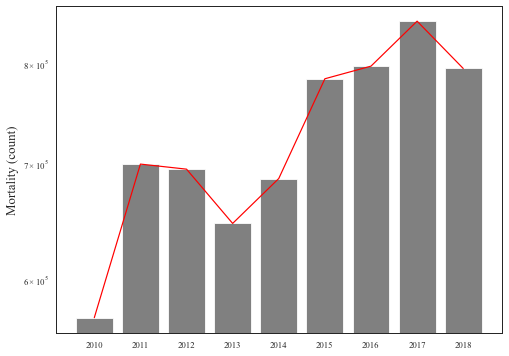

In [43]:
plt.figure(figsize=(8, 6))
plt.bar(coastal_mortalities.index, coastal_mortalities.total_mortality, color="grey")
plt.plot(coastal_mortalities.index, coastal_mortalities.total_mortality, color="red")
plt.xticks(np.arange(2010, 2019))
plt.yscale("log")
plt.ylabel("Mortality (count)", fontsize=13)
plt.savefig("outputs/coastal-mortalities-by-year.jpg", dpi=300)
plt.show()

#### 3.2.2 Offshore
- Median weight of pelagic sharks = 36 kgs
- RFMO
- Sharks only

##### 3.2.2.1 Mortality of sharks discarded alive

catch[count]

In [44]:
avg_weight = 36
total_catch = offshore[offshore.catch_type == "Discards"]["sum"].sum()
print(total_catch*1000)
n_catch = int(total_catch*1000/avg_weight)
n_catch

1038131310.6535168


28836980

In [45]:
catch_count(offshore, "discard_alive", median_weight["offshore"]) == n_catch

True

probability of being discarded alive

In [46]:
# Keep species that are not in the above list
fate_shark = fate[~fate.family.isin(non_shark_families)]
# Keep only RFMO data (not Non-RFMO means all RFMOs)
fate_non_rfmo_shark = fate_shark[fate_shark.rfmo != "Non-RFMO"]

In [47]:
# Probabilities of each fate
fate_probs = (
    fate_non_rfmo_shark.groupby(["fate_type"])["sample_size"].sum() 
    / fate_non_rfmo_shark.groupby(["fate_type"])["sample_size"].sum().sum()
)
#display(fate_probs)

# Probability of being discarded alive
discard_alive_prob = fate_probs[fate_probs.index == "discard_alive"].values[0]
discard_alive_prob

0.4458577796925144

In [48]:
p_fate(fate, "discard_alive", "offshore") == discard_alive_prob

True

probability of post-release mortality

In [49]:
mortality_shark = mortality[~mortality.family.isin(non_shark_families2)]

In [50]:
# Probability of each post release event
post_release_probs = (
    mortality_shark.groupby("estimate_type").sample_size.sum() 
    / mortality_shark.groupby("estimate_type").sample_size.sum().sum()
)
#display(post_release_probs)

# Probability of post-release mortality
discard_alive_mortality_prob = post_release_probs[post_release_probs.index == "post-release mortality"].values[0]
discard_alive_mortality_prob

0.04102341960765439

In [51]:
m_fate(mortality, "discard_alive", "offshore") == discard_alive_mortality_prob

True

**Result:**

In [52]:
# Mortality of sharks discarded alive
discard_alive_mortality = n_catch * discard_alive_prob * discard_alive_mortality_prob
discard_alive_mortality

527445.9772986046

In [53]:
# Mortality of sharks discarded alive
x = (
    catch_count(offshore, "discard_alive", median_weight["offshore"])
    *
    p_fate(fate, "discard_alive", "offshore")
    *
    m_fate(mortality, "discard_alive", "offshore")
)
x == discard_alive_mortality

True

##### 3.2.2.2 Mortality of sharks discarded dead

In [54]:
# Probability of being discarded dead
discard_dead_prob = fate_probs[fate_probs.index == "discard_dead"].values[0]
print(discard_dead_prob)

# Probability of mortality after being discarded dead is 1 (its already dead)
discard_dead_mortality_prob = 1

# Mortality of sharks discarded dead
discard_dead_mortality = n_catch * discard_dead_prob * discard_dead_mortality_prob
print(discard_dead_mortality)

0.17749973530388938
5118556.316963552


In [55]:
# Mortality of sharks discarded alive
x2 = (
    catch_count(offshore, "discard_dead", median_weight["offshore"])
    *
    p_fate(fate, "discard_dead", "offshore")
    *
    m_fate(mortality, "discard_dead", "offshore")
)
x2 == discard_dead_mortality

True

##### 3.2.2.3 Mortality of sharks retained

In [56]:
# Catch count
avg_weight = 36
total_catch = offshore[offshore.catch_type == "Landings"]["sum"].sum()
print(total_catch*1000)
n_catch = int(total_catch*1000/avg_weight)
n_catch

1106026672.5998592


30722963

In [57]:
catch_count(offshore, "retained", median_weight["offshore"]) == n_catch

True

In [58]:
# Probability of catch being retained
retained_prob = fate_probs.loc["retained_whole"]
print(retained_prob)

# Probability of retained catch mortality is 1 (fish dont survive on land)
retained_mortality_prob = 1

0.011840130851153163


In [59]:
p_fate(fate, "retained", "offshore") == retained_prob

True

In [60]:
# Mortality of sharks discarded dead
retained_mortality = n_catch * retained_prob * retained_mortality_prob
retained_mortality

363763.90205513715

In [61]:
# Mortality of sharks retained
x3 = (
    catch_count(offshore, "retained", median_weight["offshore"])
    *
    p_fate(fate, "retained", "offshore")
    *
    m_fate(mortality, "retained", "offshore")
)
x3 == retained_mortality

True

**Total mortality of Offshore Shark Spcies (rfmo)**

In [62]:
total_offshore_mortality = discard_alive_mortality + discard_dead_mortality + retained_mortality
total_offshore_mortality

6009766.196317293

In [63]:
total_offshore_mortality == (x + x2 + x3)

True

In [64]:
# offshore_mortalities = {}
# for year, data in offshore.groupby("year"):
#     totals = []
#     for f in fates:
#         n_catch = catch_count(data, f, median_weight["offshore"])
#         p = p_fate(fate, f, "offshore")
#         m = m_fate(mortality, f, "offshore")
#         mortality_fate = n_catch * p * m
#         totals.append(mortality_fate)
#     total_mortality = sum(totals)
#     print(f"{year} : {total_mortality:.2f}")
#     offshore_mortalities[year] = total_mortality

In [65]:
# plt.figure(figsize=(8, 6))
# plt.bar(offshore_mortalities.keys(), offshore_mortalities.values(), color="grey")
# plt.plot(offshore_mortalities.keys(), offshore_mortalities.values(), color="red")
# plt.yscale("log")
# plt.ylabel("Mortality (count)", fontsize=13)
# plt.savefig("outputs/offshore-mortalities-by-year.jpg", dpi=300)
# plt.show()

In [66]:
offshore_mortalities = []
for year, data in offshore.groupby("year"):
    totals = []
    for f in fates:
        n_catch = catch_count(data, f, median_weight["offshore"])
        p = p_fate(fate, f, "offshore")
        m = m_fate(mortality, f, "offshore")
        mortality_fate = n_catch * p * m
        print(f"{f} \t| {n_catch} x {p:.2f} x {m:.2f} = {mortality_fate:.2f}")
        info = {
            "year": year, 
            "fate": f, 
            "n_catch": n_catch, 
            f"p_fate": p, 
            f"m_fate": m,
            f"mortality_fate": mortality_fate,
        }
        offshore_mortalities.append(info)
        totals.append(mortality_fate)
    total_mortality = sum(totals)
    print(f"year: {year}; total mortality: {total_mortality:.2f}\n")

discard_alive 	| 3608262 x 0.45 x 0.04 = 65997.32
discard_dead 	| 3608262 x 0.18 x 1.00 = 640465.55
retained 	| 3360930 x 0.01 x 1.00 = 39793.85
year: 2010; total mortality: 746256.72

discard_alive 	| 3658802 x 0.45 x 0.04 = 66921.72
discard_dead 	| 3658802 x 0.18 x 1.00 = 649436.39
retained 	| 3622992 x 0.01 x 1.00 = 42896.70
year: 2011; total mortality: 759254.81

discard_alive 	| 3708194 x 0.45 x 0.04 = 67825.13
discard_dead 	| 3708194 x 0.18 x 1.00 = 658203.45
retained 	| 3419261 x 0.01 x 1.00 = 40484.50
year: 2012; total mortality: 766513.08

discard_alive 	| 3486336 x 0.45 x 0.04 = 63767.21
discard_dead 	| 3486336 x 0.18 x 1.00 = 618823.72
retained 	| 3160201 x 0.01 x 1.00 = 37417.19
year: 2013; total mortality: 720008.13

discard_alive 	| 3562474 x 0.45 x 0.04 = 65159.83
discard_dead 	| 3562474 x 0.18 x 1.00 = 632338.19
retained 	| 3330447 x 0.01 x 1.00 = 39432.93
year: 2014; total mortality: 736930.95

discard_alive 	| 2885546 x 0.45 x 0.04 = 52778.40
discard_dead 	| 2885546 x

In [67]:
offshore_mdf = pd.DataFrame(offshore_mortalities)
offshore_mdf.to_excel("outputs/offshore-mortalities-by-year.xlsx", index=False)
offshore_mdf

,year,fate,n_catch,p_fate,m_fate,mortality_fate
0,2010,discard_alive,3608262,0.445858,0.041023,65997.315840
1,2010,discard_dead,3608262,0.177500,1.000000,640465.549907
2,2010,retained,3360930,0.011840,1.000000,39793.850982
3,2011,discard_alive,3658802,0.445858,0.041023,66921.723309
4,2011,discard_dead,3658802,0.177500,1.000000,649436.386529
5,2011,retained,3622992,0.011840,1.000000,42896.699353
6,2012,discard_alive,3708194,0.445858,0.041023,67825.133157
7,2012,discard_dead,3708194,0.177500,1.000000,658203.453455
8,2012,retained,3419261,0.011840,1.000000,40484.497654
9,2013,discard_alive,3486336,0.445858,0.041023,63767.214830


In [68]:
offshore_mortalities = offshore_mdf.pivot_table(
    index="year",
    values="mortality_fate",
    aggfunc=np.sum,
)
offshore_mortalities.columns = ["total_mortality"]
offshore_mortalities.round(2)

,total_mortality
year,
2010,746256.72
2011,759254.81
2012,766513.08
2013,720008.13
2014,736930.95
2015,604007.34
2016,550645.71
2017,566778.27
2018,559370.55


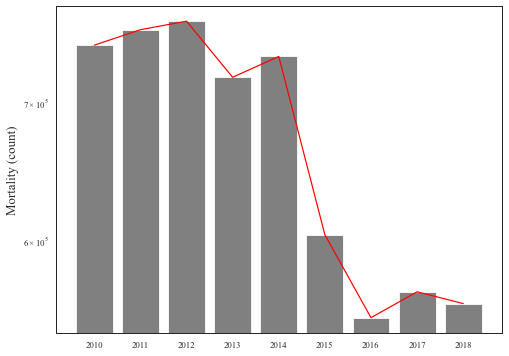

In [69]:
plt.figure(figsize=(8, 6))
plt.bar(offshore_mortalities.index, offshore_mortalities.total_mortality, color="grey")
plt.plot(offshore_mortalities.index, offshore_mortalities.total_mortality, color="red")
plt.xticks(np.arange(2010, 2019))
plt.yscale("log")
plt.ylabel("Mortality (count)", fontsize=13)
plt.savefig("outputs/offshore-mortalities-by-year.jpg", dpi=300)
plt.show()